In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
import itertools


from JDFLOW.intensity_optimization import *
from JDFLOW.signature_computation import *
from JDFLOW.stochastic_processes import *
from JDFLOW.nsde_functions import *
from JDFLOW.nsde_solvers import *
from JDFLOW.jdflow import *
from JDFLOW.evaluate.metrics import *
from JDFLOW.evaluate.monte_carlo_sim import monte_carlo_train, monte_carlo_sample
from JDFLOW.FourierFlows import FourierFlow
from JDFLOW.FSDE import train
from JDFLOW.evaluate.metrics import *
from Model import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

##### Choose any type process or upload your data. The main rule that length of each series must be the same. Available: 'DCL', 'GBM', 'Merton'.

In [21]:
data, dt, n = choose_data(name='Merton', n=300)

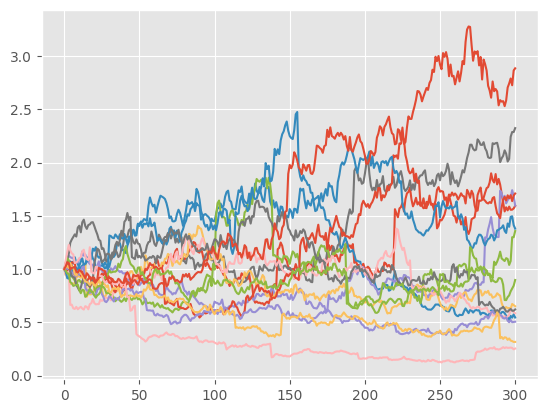

In [22]:
plt.plot(data.T)
plt.show()

#### Train the model.

In [23]:
nsde_flow, M, scaler, losses = train(data, dt, n, n_flows=10, epochs=1300, time_steps=128)

Loss: -1298.5018: 100%|██████████| 1300/1300 [07:02<00:00,  3.07it/s]


##### Generate synthetic time series.

In [24]:
synth_data = sample(nsde_flow, n_samples=10, M=M, scaler=scaler)

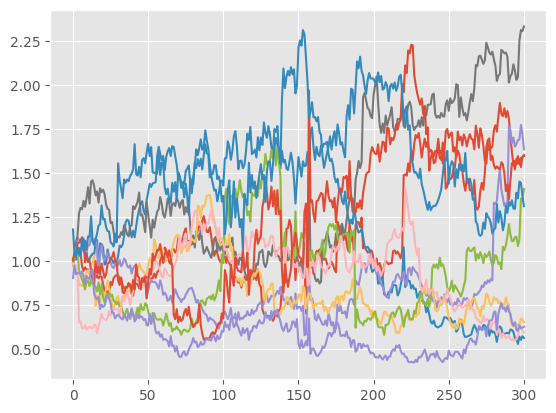

In [25]:
# plt.plot(data.T, '--', color='black', alpha=0.8, label='Real')
plt.plot(synth_data.T)

# plt.legend()
plt.show()

In [26]:
avg_synth_data = monte_carlo_sample(100, len(data), nsde_flow, M, scaler)

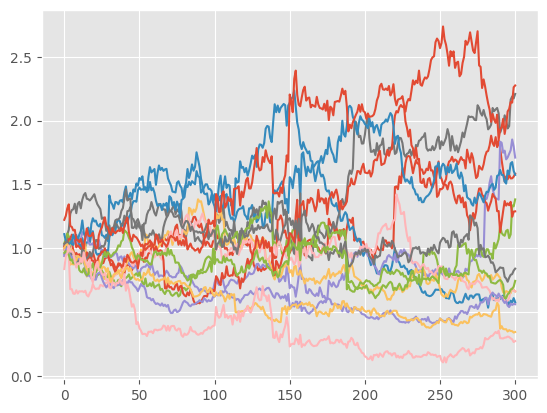

In [27]:
plt.plot(avg_synth_data.T)

plt.show()

In [11]:
# avg_tr_synth_data = monte_carlo_train(data, 2, dt, n, n_flows=8, epochs=1000, time_steps=125)

Loss: -1204.7516: 100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


In [16]:
# plt.plot(avg_tr_synth_data.T)

# plt.show()

## Hyperparameters tuning

In [1]:
from ray import tune, train
import ray
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch

In [11]:
def objective_fun(z, data, dt, n):
    n_flows, epochs, time_steps = z['n_flows'], z['epochs'], z['time_steps']
    nsde_flow, M, scaler, losses = train(data, dt, n, n_flows, epochs, time_steps)
    
    synth_data = sample(nsde_flow, n_samples=len(data), M=M, scaler=scaler)
    
    ray.train.report({'loss': w_dist_calc(synth_data, data)})

In [12]:
config = {
        "n_flows": tune.choice(np.arange(4, 12, 2)),
        "epochs": tune.choice(np.arange(700, 1200, 100)),
        "time_steps": tune.choice(np.arange(5, 130, 20)),
    }

optuna_search = OptunaSearch(
    metric='loss',
    mode="min")

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=10,
        grace_period=1,
        reduction_factor=2)

In [13]:
tuner = tune.Tuner(partial(objective_fun, data=data, dt=dt, n=n),\
                param_space=config,\
                tune_config=tune.TuneConfig(num_samples=20, search_alg=optuna_search, scheduler=scheduler),)

In [14]:
tune_result = tuner.fit()

Loss: -1231.39: 100%|██████████| 800/800 [03:32<00:00,  3.76it/s]  
2024-01-10 21:45:35,334	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'n_flows': ('__ref_ph', 'ebf8d860'), 'epochs': ('__ref_ph', 'cfeef121'), 'time_steps': ('__ref_ph', '761202b5')}
Loss: -900.2884: 100%|██████████| 800/800 [04:07<00:00,  3.23it/s]
2024-01-10 21:45:48,243	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'n_flows': ('__ref_ph', '674f5ac8'), 'epochs': ('__ref_ph', 'cfeef121'), 'time_steps': ('__ref_ph', '761202b5')}
Loss: -890.4391: 100%|██████████| 700/700 [04:57<00:00,  2.35it/s]
2024-01-10 21:46:45,363	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'n_flows': ('__ref_ph', '2944c5dd'), 'epochs': ('__ref_ph', '69f4b3a6'), 'time_steps': ('__ref_ph', '761202b5')}
Loss: -1110.5848: 100%|██████████| 800/800 [06:02<00:00,  2.21it/s]
2024-01-10 21

In [21]:
tune_result.get_best_result(metric='loss', mode='min').config

{'n_flows': 8, 'epochs': 1100, 'time_steps': 125}

In [17]:
# hyp_params = tuning_hyperparams(data, dt, n)